In [1]:
import wandb
api = wandb.Api()

# Just load seaborn & set theme and the chart looks better:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

# set matplotlib dpi to 200 to make the images bigger
plt.rcParams['figure.dpi'] = 50
wandb_cache = {}

In [2]:
metric_map = {"base": "Top1", "topk": "Top10", "skip": "Skip50-Top1", "topk_skip": "Skip50-Top10", "loss": "Loss", "perplexity": "Perplexity"}

def is_loss_metric(metric_name):
    if metric_name == "perplexity":
        return True
    if metric_name[-4:] == "loss":
        return True
    return False

def get_data(h, dataset, key):
    if key == "perplexity":
        arr = np.array([ float(x) for x in h[f"loss_data/{dataset}/loss"]])
        if np.isnan(arr[0]):
            return np.ones_like(arr)
        return np.exp(arr)
    if is_loss_metric(key):
        arr = np.array([ float(x) for x in h[f"loss_data/{dataset}/{key}"]])
        if np.isnan(arr[0]):
            return np.ones_like(arr)
        return arr
    return h[f"accuracy/{dataset}/{key}"]

def get_data_normed(h, dataset, key):
    arr = get_data(h, dataset, key)
    return arr/arr[0]

def get(h, dataset, key, normed=False):
    if normed:
        return get_data_normed(h, dataset, key)
    return get_data(h, dataset, key)

class WandbRunData:
    def __init__(self, run_name):
        self.run_name = run_name.split("https://wandb.ai/")[-1]

        if self.run_name in wandb_cache:
            self.run = api.run(self.run_name)
        else:
            self.run = api.run(self.run_name)
            wandb_cache[run_name] = self.run

        self.history = self.run.history()
        self.h = self.history
        c = self.run.config

        self.model_name = c["model_size"].split("/")[-1].lower()

        max_frac = max( c["ff_frac"], c["attn_frac"] )
        self.frac = self.history["_step"] * max_frac

        self.cripple, self.focus = c["cripple"], c["focus"]
        self.cripple_label = self.cripple
        self.focus_label   = self.focus

        # Get "unique" names
        self.name_set = self.focus_label + " " + self.cripple_label
        self.name_set_model = self.name_set + " " + self.model_name

    def get_metric(self, metric):
        if is_loss_metric(metric):
            return self.get_loss_metric(metric)
        return self.get_d_metric(metric)

    def get_d_metric(self, metric):
        self.scale = 100
        focus_perf     = get_data(self.h, self.focus,   metric) * self.scale
        cripple_perf   = get_data(self.h, self.cripple, metric) * self.scale
        return focus_perf, cripple_perf


def plot_frac_pruned(run_obj, metric, **kwargs):
    r = run_obj
    focus_perf   = get_data(r.h, r.focus, metric)
    metric_name = metric_map[metric]

    # Begin plotting
    plt.plot(r.frac*100, focus_perf, **kwargs)

    # Add details
    plt.xlim(-0.01, 100)
    plt.ylim(-0.01, None)
    plt.xlabel("% Attention Neurons Pruned")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} ({r.model_name})")
    plt.legend()

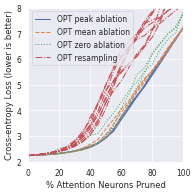

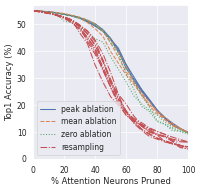

In [3]:
zero_runs = [
    "https://wandb.ai/seperability/skylar-tests/runs/0uynp8jh",
    "https://wandb.ai/seperability/skylar-tests/runs/65mutlai",
    "https://wandb.ai/seperability/skylar-tests/runs/0yzipie6",
]

peak_runs = [
    "https://wandb.ai/seperability/skylar-tests/runs/7w75etyv",
    "https://wandb.ai/seperability/skylar-tests/runs/oq6dm1hg",
    "https://wandb.ai/seperability/skylar-tests/runs/3y0c2bpo",
]

mean_runs = [
    "https://wandb.ai/seperability/skylar-tests/runs/rkdciwru",
    "https://wandb.ai/seperability/skylar-tests/runs/x08q40mt",
    "https://wandb.ai/seperability/skylar-tests/runs/f89crwxn",
]

resampling_runs = [
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/vym906gg", # chars
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/fzslaasi",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/0xuqkgl6",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/gbx72pqm", # ids
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/svdxk3dd",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/7xvhv1et",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/f2c5u5aq", # gen
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/qgfx1vv1",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/emvl6tz3"
]

plt.figure(figsize=(4,4))
metric = "loss"
for i, x in enumerate(peak_runs):
    label = "OPT peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "OPT mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "OPT zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
for i, x in enumerate(resampling_runs):
    label = "OPT resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
plt.ylim(2, 8)
plt.ylabel("Cross-entropy Loss (lower is better)")
plt.title("")
plt.show()

plt.figure(figsize=(4,4))
metric = "base"
for i, x in enumerate(peak_runs):
    label = "peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
for i, x in enumerate(resampling_runs):
    label = "resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
plt.ylim(None, None)
plt.ylabel("Top1 Accuracy (%)")
plt.title("")
plt.show()

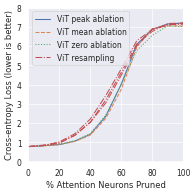

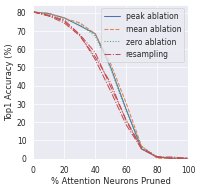

In [4]:
peak_runs = [
    "https://wandb.ai/seperability/nicky-peaks-test/runs/2ew9tibt"
]

zero_runs = [
    "https://wandb.ai/seperability/nicky-peaks-test/runs/hxd3k4b0",
]

mean_runs = [
    "https://wandb.ai/seperability/nicky-peaks-test/runs/bunfnz1s",
]

resampling_runs = [
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/r3owylrg",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/9bfkdzrp",
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/snp9go7b"
]

plt.figure(figsize=(4,4))
metric = "loss"
for i, x in enumerate(peak_runs):
    label = "ViT peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "ViT mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "ViT zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
for i, x in enumerate(resampling_runs):
    label = "ViT resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
plt.ylim(None, 8)
plt.ylabel("Cross-entropy Loss (lower is better)")
plt.title("")
plt.show()

plt.figure(figsize=(4,4))
metric = "base"
for i, x in enumerate(peak_runs):
    label = "peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
for i, x in enumerate(resampling_runs):
    label = "resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
plt.ylim(None, None)
plt.ylabel("Top1 Accuracy (%)")
plt.title("")
plt.show()

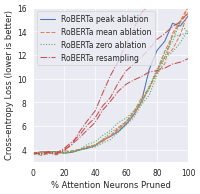

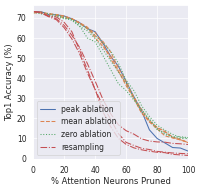

In [5]:
# ROBERTA

peak_runs = [
    "https://wandb.ai/seperability/nicky-peaks-test/runs/hy3eax7d"
]

zero_runs = [
    "https://wandb.ai/seperability/nicky-peaks-test/runs/kl65988t",
    "https://wandb.ai/seperability/nicky-peaks-test/runs/i0niy05a",
    "https://wandb.ai/seperability/nicky-peaks-test/runs/kvvhf9o8",
]

mean_runs = [
    "https://wandb.ai/seperability/nicky-peaks-test/runs/k9illdfp",
    "https://wandb.ai/seperability/nicky-peaks-test/runs/pg5k66sw",
    "https://wandb.ai/seperability/nicky-peaks-test/runs/su9pkfjc",
]

resampling_runs = [
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/adh7wilv", # char
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/46xxl6b7", # ids
    "https://wandb.ai/seperability/nicky-resampling-testing/runs/ex7yo3bg", # gen
]

plt.figure(figsize=(4,4))
metric = "loss"
for i, x in enumerate(peak_runs):
    label = "RoBERTa peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "RoBERTa mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "RoBERTa zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
for i, x in enumerate(resampling_runs):
    label = "RoBERTa resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
plt.ylim(3, 16)
plt.ylabel("Cross-entropy Loss (lower is better)")
plt.title("")
plt.show()

plt.figure(figsize=(4,4))
metric = "base"
for i, x in enumerate(peak_runs):
    label = "peak ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, color="C0", label=label)
for i, x in enumerate(mean_runs):
    label = "mean ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="--", color="C1", label=label)
for i, x in enumerate(zero_runs):
    label = "zero ablation" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle=":", color="C2", label=label)
for i, x in enumerate(resampling_runs):
    label = "resampling" if i == 0 else ""
    plot_frac_pruned(WandbRunData(x), metric, linestyle="-.", color="C3", label=label)
plt.ylim(None, None)
plt.ylabel("Top1 Accuracy (%)")
plt.title("")
plt.show()